In this analysis, we will determine if there is a correlation between income level and a diagnosis of diabetes.

We will be using the Diabetes Health Indicators Dataset from Kaggle, last updated two years ago.

In this dataset, 0 is for no diabetes or only during pregnancy, 1 is for prediabetes, and 2 is for diabetes. This dataset has a class imbalance. 

In [1]:

import numpy as np
from datascience import *

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [2]:
# Import dataset as data
data = Table.read_table('diabetes_012_health_indicators_BRFSS2015.csv')

# First five rows
data.show(5)

Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,0,1,0,5,18,15,1,0,9,4,3
0,0,0,0,25,1,0,0,1,0,0,0,0,1,3,0,0,0,0,7,6,1
0,1,1,1,28,0,0,0,0,1,0,0,1,1,5,30,30,1,0,9,4,8
0,1,0,1,27,0,0,0,1,1,1,0,1,0,2,0,0,0,0,11,3,6
0,1,1,1,24,0,0,0,1,1,1,0,1,0,2,3,0,0,0,11,5,4


Let's compare 'Income' with diabetes

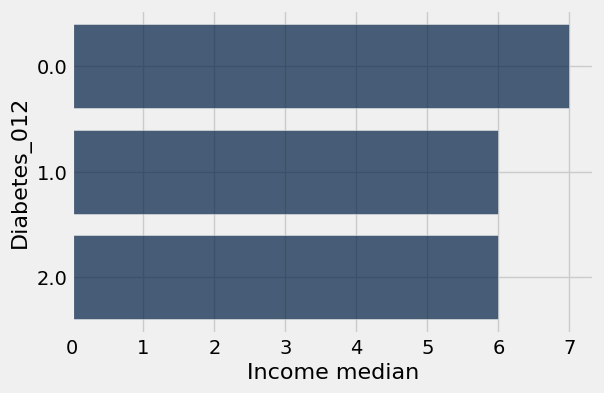

In [3]:
selected = data.select("Income", "Diabetes_012")

selected_group = selected.group("Diabetes_012", collect = np.median)
selected_group.barh("Diabetes_012")



As we can see, there is a higher median income level (7) for those without diabetes or only during pregnancy, and a lower median income (6) for both those who are prediabetic and those who have diabetes.

Next, we'll clean the data. We will change the name of our diabetes variable to be more clear and drop unused variables.

In [4]:
# change character variables to dummy variables
data_dummy = data.with_columns('Label Diabetes', data.column('Diabetes_012'))


# drop old variables + weight 
data_clean = data_dummy.drop('Diabetes_012','HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
                            'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
                            'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 
                            'Sex', 'Age', 'Education')

data_clean

Income,Label Diabetes
3,0
1,0
8,0
6,0
4,0
8,0
7,0
4,0
1,2
3,0


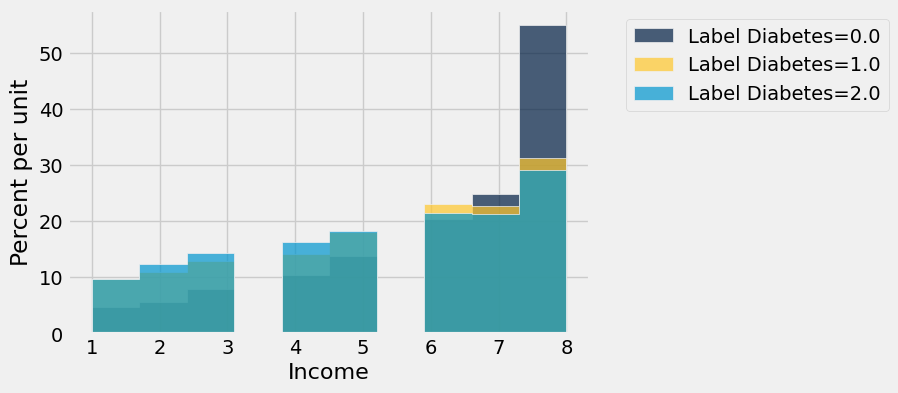

In [5]:
# make histogram
data_clean.hist("Income", group = "Label Diabetes")

## Hypothesis test

We can see that by far, the highest proportion of those without diabetes are those with a high income, whereas prediabetic and diabetic people had more of a spread throughout the income groups. We will now do a hypothesis test to see if there is truly a significant correlation between the two variables.

My null hypothesis is that there is no relationship between income and prediabetes/diabetes. My alternative hypothesis is that there is a relationship between income and prediabetes/diabetes.

In [6]:
income_and_diabetes = data_clean.select('Label Diabetes', 'Income')
income_and_diabetes.group('Label Diabetes', collect = np.mean)

Label Diabetes,Income mean
0,6.20866
1,5.35111
2,5.21009


In [7]:
diabetes_by_income = income_and_diabetes.group('Label Diabetes', collect = np.mean)
diabetes_by_income.column('Income mean').item(1) - diabetes_by_income.column('Income mean').item(0)
                                               

-0.8575513545811244

In [8]:
def statistic(diabetes_table):
    """
    Arguments:
    diabetes_table, Table: a table that looks like the data table
    
    Returns:
    a statistic that compares the means of the two groups
    """
    diabetes_by_income = diabetes_table.group("Label Diabetes", collect = np.mean)
    return diabetes_by_income.column("Income mean").item(1) - diabetes_by_income.column("Income mean").item(0)

observed_statistic = statistic(income_and_diabetes)
observed_statistic

-0.8575513545811244

Now let's shuffle our income_and_diabetes table and assign the shuffled table to shuffled_income. We will create a new table called simulated_income that contains the original 'Income' variable and also a shuffled 'Label Diabetes' variable


In [9]:
shuffled_income = income_and_diabetes.sample(income_and_diabetes.num_rows).column('Label Diabetes')
simulated_income = Table().with_columns('Income', income_and_diabetes.column('Income'),
                                        'Label Diabetes', shuffled_income)

simulated_income

Income,Label Diabetes
3,0
1,0
8,0
6,2
4,2
8,0
7,0
4,1
1,2
3,0


Let's calculate the statistic of the simulated table.

In [10]:
statistic(simulated_income)

0.020668009666379383

Let's test the distribution under the null hypothesis with a function and loop.

In [11]:
def simulation_and_statistic():
    """
    Simulates shuffing the income_and_diabetes table and calculating the statistics.
    
    Returns one statistic.
    """
    shuffled_income = income_and_diabetes.sample(income_and_diabetes.num_rows).column("Label Diabetes")
    simulated_income = Table().with_columns("Income", income_and_diabetes.column("Income"),
                                        "Label Diabetes", shuffled_income)
    return statistic(simulated_income)

num_repetitions = 100

simulated_statistics = make_array()
for trial in np.arange(num_repetitions):
    simulated_statistics = np.append(simulated_statistics, simulation_and_statistic())

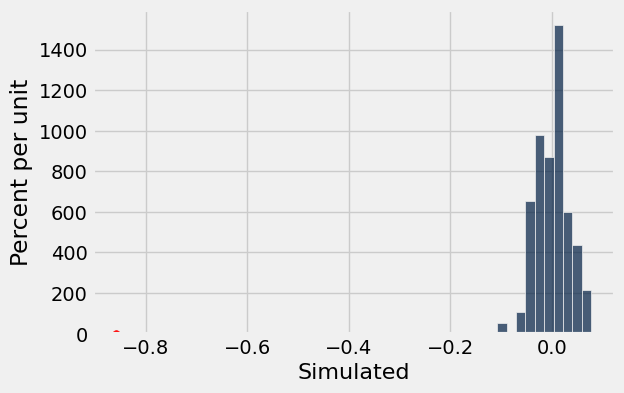

In [12]:
# visualize with a histogram and a red dot representing observed statistic
Table().with_columns("Simulated", simulated_statistics).hist()
plt.scatter(observed_statistic, 0, color='red', s=30);

It looks like our observed statistic is not close to most other data points. Let's calculate the probability that we get the observed statistic if the null hypothesis were true.

In [13]:
np.sum(simulated_statistics <= observed_statistic) / num_repetitions

0.0

## Prediction
Now, we will use income and other factors to predict diabetes prevelance.

In [14]:
import pandas as pd

# create new csv with index called 'ID'

# add index
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

# Reset index to create a new index column
data.reset_index(inplace=True)

# Rename the index column to 'ID' or any other suitable name
data.rename(columns={'index': 'ID'}, inplace=True)

# Save the modified DataFrame back to a CSV file
data.to_csv("with_index.csv", index=False)

In [15]:


data_two = pd.read_csv('with_index.csv')

# Initialize dictionaries for mappings
person_outcome_map = {}
health_factors_map = {}

# Iterate through each row in the DataFrame
for index, row in data_two.iterrows():
    # Extract relevant information from the row
    income = row['Income']
    diabetes_outcome = row["Diabetes_012"]
    chol_check = row['CholCheck']
    healthcare = row['AnyHealthcare']
    phys_activity = row['PhysActivity']
    fruits = row['Fruits']
    

    # Update person_outcome_map with automatically generated index
    person_outcome_map[index] = {"person": index, "diabetes_outcome": diabetes_outcome}

    # Update health_factors_map with automatically generated index
    health_factors_map[index] = {
        "income": income,
        "chol_check": chol_check,
        "healthcare": healthcare,
        "phys_activity": phys_activity,
        "fruits": fruits,
        "diabetes_outcome": diabetes_outcome, 
        
    }

# Access the mappings:
# person_outcome_map contains each person's diabetes outcome with corresponding index
# health_factors_map contains each person's health factors and diabetes outcome with corresponding index

# Test index of 1
print(health_factors_map[1])

{'income': 1.0, 'chol_check': 0.0, 'healthcare': 0.0, 'phys_activity': 1.0, 'fruits': 0.0, 'diabetes_outcome': 0.0}


In [95]:
test_person_id = 34
test_person_object = health_factors_map[test_person_id]
test_person_object

{'income': 3.0,
 'chol_check': 1.0,
 'healthcare': 1.0,
 'phys_activity': 0.0,
 'fruits': 0.0,
 'diabetes_outcome': 2.0}

## Euclidean Distance

Now we will calculate the Euclidean distance of people based on these health factors. We will create a distance matrix that contains Euclidean distances between all pairs of individuals in this dataset.

In [102]:
import numpy as np


# Function to calculate Euclidean distance between two feature vectors
def euclidean_distance(feature_vector1, feature_vector2):
    return np.sqrt(np.sum((feature_vector1[:-1] - feature_vector2[:-1]) ** 2))

# Select a random sample of 2,500 individuals from your dataset
num_people = len(health_factors_map)
sample_size = 2500
if num_people < sample_size:
    raise ValueError("Sample size cannot be greater than the number of people in the dataset.")

sample_indices = np.random.choice(range(num_people), size=sample_size, replace=False)

# Initialize an empty distance matrix for the sample
sample_distance_matrix = np.zeros((sample_size, sample_size))

# Calculate Euclidean distance for each pair of individuals in the sample
for i, person1_index in enumerate(sample_indices):
    for j, person2_index in enumerate(sample_indices):
        # Skip comparing the same individual
        if i == j:
            continue
        
        # Extract feature vectors for the two individuals
        person1_id = person1_index
        person2_id = person2_index
        if person1_id not in health_factors_map:
            test_person_object = health_factors_map[person1_id]
            print(test_person_object)
            print(f"Person ID {person1_id} does not exist in the health factors map.")
            continue
        if person2_id not in health_factors_map:
            test_person_object = health_factors_map[person2_id]
            print(test_person_object)
            print(f"Person ID {person2_id} does not exist in the health factors map.")
            continue
        
        features_person1 = np.array(list(health_factors_map[person1_id].values()))
        features_person2 = np.array(list(health_factors_map[person2_id].values()))
        
        # Calculate Euclidean distance and store in the sample distance matrix
        sample_distance_matrix[i, j] = euclidean_distance(features_person1, features_person2)

# Now, sample_distance_matrix[i, j] contains the Euclidean distance between person i and person j in the sample

sample_distance_matrix[34, 3]


4.1231056256176606

In [103]:
# Find Euclidean distance with test person
rows = []
sample_person_id = 34
# Extract feature vector for the sample person
sample_features = np.array(list(health_factors_map[sample_person_id].values()))
# Calculate Euclidean distance between the sample person and all other individuals
for other_person_id in health_factors_map:
    # Skip comparing with the sample person itself
    if other_person_id == sample_person_id:
        continue
    
    # Extract feature vector for the other person
    other_features = np.array(list(health_factors_map[other_person_id].values()))
    
    # Calculate Euclidean distance
    distance = euclidean_distance(sample_features, other_features)
    
    # Calculate similarity based on distance
    similarity = 1 / (1 + distance)
    
    # Append to the rows list
    rows.append({
        "sample_person_id": sample_person_id,
        "other_person_id": other_person_id,
        "similarity": similarity
    })

In [104]:
# Create similarity dataframe

similar_df = pd.DataFrame(rows)
similar_df

,sample_person_id,other_person_id,similarity
0,34,0,1.000000
1,34,1,0.274292
2,34,2,0.163961
3,34,3,0.231662
4,34,4,0.366025
...,...,...,...
253674,34,253675,0.195194
253675,34,253676,0.500000
253676,34,253677,0.366025
253677,34,253678,0.309017


In [105]:
similar_df.head(5)

,sample_person_id,other_person_id,similarity
0,34,0,1.000000
1,34,1,0.274292
2,34,2,0.163961
3,34,3,0.231662
4,34,4,0.366025


In [106]:
topk = 5
top_k_df = similar_df.sort_values(by="similarity", ascending=False).head(topk)
top_k_df

,sample_person_id,other_person_id,similarity
0,34,0,1.0
9,34,9,1.0
66496,34,66497,1.0
253627,34,253628,1.0
253656,34,253657,1.0


In [107]:
health_factors_map[34]

{'income': 3.0,
 'chol_check': 1.0,
 'healthcare': 1.0,
 'phys_activity': 0.0,
 'fruits': 0.0,
 'diabetes_outcome': 2.0}

In [108]:
health_factors_map[0]

{'income': 3.0,
 'chol_check': 1.0,
 'healthcare': 1.0,
 'phys_activity': 0.0,
 'fruits': 0.0,
 'diabetes_outcome': 0.0}

In [109]:
health_factors_map[9]

{'income': 3.0,
 'chol_check': 1.0,
 'healthcare': 1.0,
 'phys_activity': 0.0,
 'fruits': 0.0,
 'diabetes_outcome': 0.0}

In [110]:
health_factors_map[66497]

{'income': 3.0,
 'chol_check': 1.0,
 'healthcare': 1.0,
 'phys_activity': 0.0,
 'fruits': 0.0,
 'diabetes_outcome': 0.0}

In [111]:
health_factors_map[253628]

{'income': 3.0,
 'chol_check': 1.0,
 'healthcare': 1.0,
 'phys_activity': 0.0,
 'fruits': 0.0,
 'diabetes_outcome': 2.0}

In [112]:
health_factors_map[253657]

{'income': 3.0,
 'chol_check': 1.0,
 'healthcare': 1.0,
 'phys_activity': 0.0,
 'fruits': 0.0,
 'diabetes_outcome': 0.0}

In [113]:
# Initialize dictionary to store count of each combination of factors and diabetes outcome
combination_count = {}

# Iterate through each person in top-k
for other_person_id in top_k_df["other_person_id"]:
    other_person_info = health_factors_map[other_person_id]
    
    # Extract the values of all the factors for the other person
    factor_values = tuple(other_person_info.values())[:-1]  # Exclude the last value which is the diabetes outcome
    
    # Combine factor values into a tuple
    factor_combination = tuple(factor_values)
    
    # Update dictionary count for the combination
    combination_count[factor_combination] = combination_count.get(factor_combination, 0) + 1


In [114]:
combination_count

{(3.0, 1.0, 1.0, 0.0, 0.0): 5}

In [115]:
from collections import Counter

In [116]:
# Initialize Counter to store count of each diabetes outcome among individuals with similar health factors
diabetes_outcome_counter = Counter()

# Iterate through each person in top_k_df
for other_person_id in top_k_df["other_person_id"]:
    other_person_info = health_factors_map[other_person_id]
    
    # Extract the diabetes outcome for the other person
    diabetes_outcome = other_person_info["diabetes_outcome"]
    
    # Increment the count for the diabetes outcome in the Counter
    diabetes_outcome_counter[diabetes_outcome] += 1

# Determine the most common diabetes outcome
predicted_diagnosis = diabetes_outcome_counter.most_common(1)[0][0]

# Print the predicted diagnosis
print("Predicted Diagnosis:", predicted_diagnosis)


Predicted Diagnosis: 0.0


In [117]:
# Check if predicted diagnosis matches the test person's actual diagnosis
predicted_diagnosis_matches_test = predicted_diagnosis == test_person_object["diabetes_outcome"]
predicted_diagnosis_matches_test


False

In [118]:
from collections import Counter

# Initialize Counter to store count of each combination of health factors and diabetes outcome
health_factors_diagnosis_count = Counter()

# Iterate through each person in top_k_df
for other_person_id in top_k_df["other_person_id"]:
    other_person_info = health_factors_map[other_person_id]
    
    # Extract health factor values for the other person
    factor_values = tuple(other_person_info.values())[:-1]  # Exclude the last value which is the diabetes outcome
    
    # Combine health factor values into a tuple
    factor_combination = tuple(factor_values)
    
    # Increment the count for the combination in the Counter
    health_factors_diagnosis_count[factor_combination] += 1

# Calculate count of the most common combination
most_common_count = health_factors_diagnosis_count.most_common(1)[0][1]

print("Most common count:", most_common_count)


Most common count: 5


In [119]:
# Calculate accuracy
accuracy = 1 if predicted_diagnosis_matches_test else 0

# Print accuracy
print("Accuracy:", accuracy)


Accuracy: 0


## Predict Diabetes Outcome

In [149]:
sim_outcomes = []

# Iterate through each person in top-k 
for other_person_id in top_k_df["other_person_id"]:
    # Take corresponding person object from health_factors_map
    other_person_object = health_factors_map[other_person_id]
    
    # Append the diabetes outcome of other person to sim_outcomes
    sim_outcomes.append(other_person_object["diabetes_outcome"])

In [150]:
top_k_df

,sample_person_id,other_person_id,similarity
0,34,0,1.0
9,34,9,1.0
66496,34,66497,1.0
253627,34,253628,1.0
253656,34,253657,1.0


In [125]:
from collections import Counter

# Count occurrences of each diabetes outcome
outcome_counts = Counter(sim_outcomes)

# Print counts
print(outcome_counts)

Counter({0.0: 4, 2.0: 1})


In [126]:
# Convert strings to integers
sim_outcomes_numeric = [int(outcome) for outcome in sim_outcomes]

# Calculate the mean
mean_outcome = np.mean(sim_outcomes_numeric)
mean_outcome

0.40000000000000002

In [127]:
scores = []
for k in range(1,10):
    print(k)
    this_top_k_df = similar_df.sort_values(by="similarity", ascending=False).head(k)
    
    sim_outcomes = []
    for other_person_id in this_top_k_df["other_person_id"]:
        other_person_object = health_factors_map[other_person_id]

        # convert to integer and append to sim_outcomes
        sim_outcomes.append(int(other_person_object["diabetes_outcome"]))

    # Calculate mean outcome & squared error
    mean_outcome = np.mean(sim_outcomes)
    squared_error = (mean_outcome - int(test_person_object["diabetes_outcome"])) ** 2

    # Print calculated scores
    print("Mean outcome:", mean_outcome)
    print("Squared error:", squared_error)
    
    scores.append({
        "k": k,
        "predicted_outcome": mean_outcome,
        "se": squared_error
    })

1
Mean outcome: 0.0
Squared error: 4.0
2
Mean outcome: 0.0
Squared error: 4.0
3
Mean outcome: 0.0
Squared error: 4.0
4
Mean outcome: 0.5
Squared error: 2.25
5
Mean outcome: 0.4
Squared error: 2.56
6
Mean outcome: 0.666666666667
Squared error: 1.77777777778
7
Mean outcome: 0.857142857143
Squared error: 1.30612244898
8
Mean outcome: 0.75
Squared error: 1.5625
9
Mean outcome: 0.888888888889
Squared error: 1.23456790123


In [128]:
pd.DataFrame(scores)

,k,predicted_outcome,se
0,1,0.000000,4.000000
1,2,0.000000,4.000000
2,3,0.000000,4.000000
3,4,0.500000,2.250000
4,5,0.400000,2.560000
5,6,0.666667,1.777778
6,7,0.857143,1.306122
7,8,0.750000,1.562500
8,9,0.888889,1.234568


<Axes: xlabel='k'>

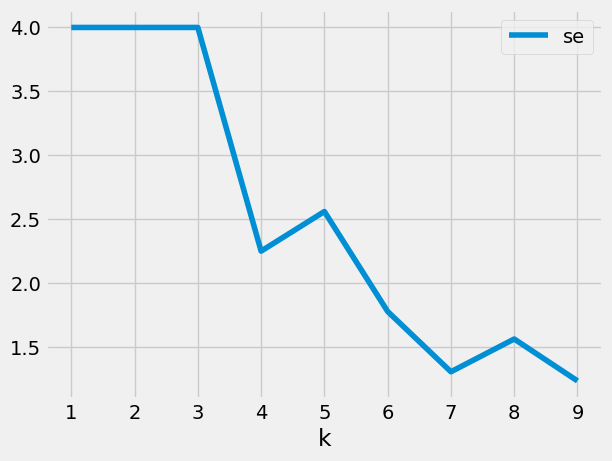

In [129]:
pd.DataFrame(scores).plot(x="k", y="se")

In [130]:
import random

In [131]:
len(health_factors_map.keys())

253680

In [155]:
import random

all_person_ids = list(health_factors_map.keys())
random.shuffle(all_person_ids)

# Calculate the number of test person IDs based on the desired split
num_test_person_ids = int(0.20 * len(all_person_ids))

# Split the shuffled IDs into test and train
test_person_ids = all_person_ids[:num_test_person_ids]
other_person_ids = all_person_ids[num_test_person_ids:]


In [157]:
global_person_map = {}

test_person_id = 34

# Check if test person ID is present in health_factors_map
if test_person_id in health_factors_map:
    # Take info about the test person from health_factors_map
    test_person_object = health_factors_map[test_person_id]

    scores = []

    # Iterate over k values
    for k in range(1, 20):
        # Sort similar_df by similarity and select top k rows
        this_top_k_df = similar_df.sort_values(by="similarity", ascending=False).head(k)

        # Initialize list to store outcomes for each similar person
        sim_outcomes = []

        # Iterate over person_ids in top k
        for other_person_id in this_top_k_df["other_person_id"]:
            other_person_object = health_factors_map[other_person_id]

            # Append numeric outcome to sim_outcomes
            sim_outcomes.append(float(other_person_object["diabetes_outcome"]))  # Convert to float

        # Calculate mean of sim_outcomes
        mean_outcome = np.mean(sim_outcomes)

        # Convert target_person_object["diabetes_outcome"] to float
        target_diabetes_outcome = float(test_person_object["diabetes_outcome"])

        # Determine predicted outcome based on rounded mean
        predicted_diabetes = round(mean_outcome / 2) * 2

        # Calculate squared error
        squared_error = (mean_outcome - target_diabetes_outcome) ** 2

        # Append k, predicted_outcome, and squared error to scores list
        scores.append({
            "k": k,
            "predicted_outcome": predicted_diabetes,
            "se": squared_error
        })

    # Convert scores list to DataFrame and store in global_person_map
    global_person_map[test_person_id] = pd.DataFrame(scores)

    # Get predicted outcome for test person from global_person_map
    predicted_df = global_person_map[test_person_id]

    # Get test person predicted outcome
    predicted_outcome = predicted_df[predicted_df["k"] == 13]["predicted_outcome"].values[0]  # Replace k with the desired value of k

    # Get test person's actual outcome from the health_person_map
    actual_outcome = float(test_person_object.get("diabetes_outcome", -1))

    if actual_outcome != -1:
        # Compare predicted outcome with the actual outcome
        if predicted_outcome == actual_outcome:
            print("Prediction is correct!")
        else:
            print("Prediction is incorrect!")
    else:
        print("Actual outcome not available for the test person.")
else:
    print("Test person not found in health_factors_map.")


Prediction is correct!


In [140]:
global_person_map

{34:      k  predicted_outcome        se
 0    1                  0  4.000000
 1    2                  0  4.000000
 2    3                  0  4.000000
 3    4                  0  2.250000
 4    5                  0  2.560000
 5    6                  0  1.777778
 6    7                  0  1.306122
 7    8                  0  1.562500
 8    9                  0  1.234568
 9   10                  0  1.000000
 10  11                  2  0.826446
 11  12                  2  0.694444
 12  13                  2  0.591716
 13  14                  2  0.734694
 14  15                  2  0.871111
 15  16                  2  0.765625
 16  17                  2  0.678201
 17  18                  2  0.790123
 18  19                  2  0.897507}

In [141]:
k_se_scores = {}
for k_df in global_person_map.values():
    for _,row in k_df.iterrows():
        k_se_scores[row["k"]] = k_se_scores.get(row["k"], []) + [row["se"]]

In [142]:
np.mean(k_se_scores[13])

0.59171597633136086

In [143]:
np.mean(k_se_scores[3])

4.0

<Axes: xlabel='0'>

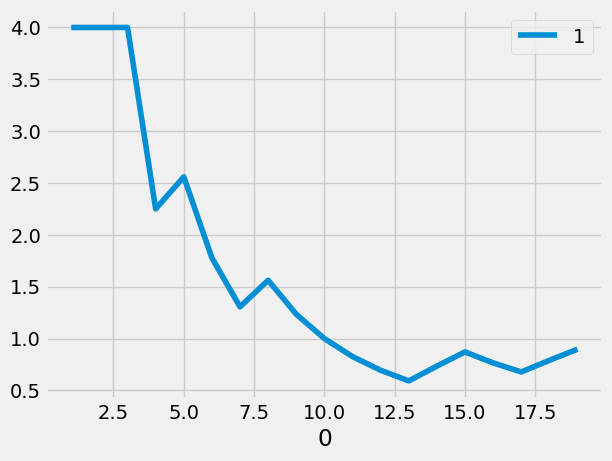

In [144]:
pd.DataFrame([(k,np.mean(v)) for k,v in k_se_scores.items()]).plot(x=0, y=1)

Counts for income level 1:

In [145]:
# Initialize counts for each factor level and each diabetes outcome
count_factor_level_0_diabetes_0 = 0
count_factor_level_0_diabetes_1 = 0
count_factor_level_0_diabetes_2 = 0
# Repeat for each factor level as needed...

# Iterate through health_factors_map
for person_info in health_factors_map.values():
    factor_level = person_info["income"]
    diabetes_outcome = person_info["diabetes_outcome"]

    # Check if factor level is 0 and diabetes outcome is 0 or 1
    if factor_level == 1:
        if diabetes_outcome == 0:
            count_factor_level_0_diabetes_0 += 1
        if diabetes_outcome == 1:
            count_factor_level_0_diabetes_1 += 1
        elif diabetes_outcome == 2:
            count_factor_level_0_diabetes_2 += 1


# Print counts
print("Instances of factor level 0 for individuals with diabetes outcome 0:", count_factor_level_0_diabetes_0)
print("Instances of factor level 0 for individuals with diabetes outcome 1:", count_factor_level_0_diabetes_1)
print("Instances of factor level 0 for individuals with diabetes outcome 2:", count_factor_level_0_diabetes_2)




Instances of factor level 0 for individuals with diabetes outcome 0: 7114
Instances of factor level 0 for individuals with diabetes outcome 1: 314
Instances of factor level 0 for individuals with diabetes outcome 2: 2383


Counts for chol_check:

In [146]:
# Initialize counts for each factor level and each diabetes outcome
count_factor_level_0_diabetes_0 = 0
count_factor_level_0_diabetes_1 = 0
count_factor_level_0_diabetes_2 = 0
# Repeat for each factor level as needed...

# Iterate through health_factors_map
for person_info in health_factors_map.values():
    factor_level = person_info["chol_check"]
    diabetes_outcome = person_info["diabetes_outcome"]

    # Check if factor level is 0 and diabetes outcome is 0 or 1
    if factor_level == 0:
        if diabetes_outcome == 0:
            count_factor_level_0_diabetes_0 += 1
        if diabetes_outcome == 1:
            count_factor_level_0_diabetes_1 += 1
        elif diabetes_outcome == 2:
            count_factor_level_0_diabetes_2 += 1


# Print counts
print("Instances of factor level 0 for individuals with diabetes outcome 0:", count_factor_level_0_diabetes_0)
print("Instances of factor level 0 for individuals with diabetes outcome 1:", count_factor_level_0_diabetes_1)
print("Instances of factor level 0 for individuals with diabetes outcome 2:", count_factor_level_0_diabetes_2)

Instances of factor level 0 for individuals with diabetes outcome 0: 9167
Instances of factor level 0 for individuals with diabetes outcome 1: 62
Instances of factor level 0 for individuals with diabetes outcome 2: 241


Counts for healthcare:

In [148]:
# Initialize counts for each factor level and each diabetes outcome
count_factor_level_0_diabetes_0 = 0
count_factor_level_0_diabetes_1 = 0
count_factor_level_0_diabetes_2 = 0
# Repeat for each factor level as needed...

# Iterate through health_factors_map
for person_info in health_factors_map.values():
    factor_level = person_info["healthcare"]
    diabetes_outcome = person_info["diabetes_outcome"]

    # Check if factor level is 0 and diabetes outcome is 0 or 1
    if factor_level == 0:
        if diabetes_outcome == 0:
            count_factor_level_0_diabetes_0 += 1
        if diabetes_outcome == 1:
            count_factor_level_0_diabetes_1 += 1
        elif diabetes_outcome == 2:
            count_factor_level_0_diabetes_2 += 1


# Print counts
print("Instances of factor level 0 for individuals with diabetes outcome 0:", count_factor_level_0_diabetes_0)
print("Instances of factor level 0 for individuals with diabetes outcome 1:", count_factor_level_0_diabetes_1)
print("Instances of factor level 0 for individuals with diabetes outcome 2:", count_factor_level_0_diabetes_2)

Instances of factor level 0 for individuals with diabetes outcome 0: 10741
Instances of factor level 0 for individuals with diabetes outcome 1: 254
Instances of factor level 0 for individuals with diabetes outcome 2: 1422


Counts for phys_activity:

In [147]:
# Initialize counts for each factor level and each diabetes outcome
count_factor_level_0_diabetes_0 = 0
count_factor_level_0_diabetes_1 = 0
count_factor_level_0_diabetes_2 = 0
# Repeat for each factor level as needed...

# Iterate through health_factors_map
for person_info in health_factors_map.values():
    factor_level = person_info["phys_activity"]
    diabetes_outcome = person_info["diabetes_outcome"]

    # Check if factor level is 0 and diabetes outcome is 0 or 1
    if factor_level == 0:
        if diabetes_outcome == 0:
            count_factor_level_0_diabetes_0 += 1
        if diabetes_outcome == 1:
            count_factor_level_0_diabetes_1 += 1
        elif diabetes_outcome == 2:
            count_factor_level_0_diabetes_2 += 1


# Print counts
print("Instances of factor level 0 for individuals with diabetes outcome 0:", count_factor_level_0_diabetes_0)
print("Instances of factor level 0 for individuals with diabetes outcome 1:", count_factor_level_0_diabetes_1)
print("Instances of factor level 0 for individuals with diabetes outcome 2:", count_factor_level_0_diabetes_2)

Instances of factor level 0 for individuals with diabetes outcome 0: 47212
Instances of factor level 0 for individuals with diabetes outcome 1: 1489
Instances of factor level 0 for individuals with diabetes outcome 2: 13059


Counts for 'fruits':

In [79]:
# Initialize counts for each factor level and each diabetes outcome
count_factor_level_0_diabetes_0 = 0
count_factor_level_0_diabetes_1 = 0
count_factor_level_0_diabetes_2 = 0
# Repeat for each factor level as needed...

# Iterate through health_factors_map
for person_info in health_factors_map.values():
    factor_level = person_info["fruits"]
    diabetes_outcome = person_info["diabetes_outcome"]

    # Check if factor level is 0 and diabetes outcome is 0 or 1
    if factor_level == 0:
        if diabetes_outcome == 0:
            count_factor_level_0_diabetes_0 += 1
        if diabetes_outcome == 1:
            count_factor_level_0_diabetes_1 += 1
        elif diabetes_outcome == 2:
            count_factor_level_0_diabetes_2 += 1


# Print counts
print("Instances of factor level 0 for individuals with diabetes outcome 0:", count_factor_level_0_diabetes_0)
print("Instances of factor level 0 for individuals with diabetes outcome 1:", count_factor_level_0_diabetes_1)
print("Instances of factor level 0 for individuals with diabetes outcome 2:", count_factor_level_0_diabetes_2)

Instances of factor level 0 for individuals with diabetes outcome 0: 76287
Instances of factor level 0 for individuals with diabetes outcome 1: 1842
Instances of factor level 0 for individuals with diabetes outcome 2: 14653
